In [30]:
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split

import sys
sys.path.append("../../")

import biked_commons
from biked_commons.prediction import aero_predictor, loaders
from biked_commons import resource_utils


In [33]:
X_tv, Y_tv = loaders.load_aero()

In [34]:
X_tv

,hand_x,hand_y,hip_x,hip_y,crank_length,upper_leg,lower_leg,arm_length,torso_length,neck_and_head_length,torso_width
1161,0.539590,0.536453,0.427000,0.681000,0.175000,0.457742,0.533926,0.687155,0.535995,0.288442,0.338117
2355,0.471688,0.475275,0.426000,0.681000,0.173000,0.385622,0.547221,0.648593,0.525186,0.302046,0.302120
1831,0.435000,0.489000,0.442000,0.343000,0.173000,0.388114,0.497758,0.705805,0.496954,0.287635,0.364465
156,0.383192,0.671496,0.346000,0.367000,0.173000,0.412393,0.518318,0.694971,0.571948,0.329807,0.304491
195,0.532379,0.504070,0.401000,0.650000,0.170000,0.371987,0.512847,0.614458,0.562886,0.297272,0.325182
...,...,...,...,...,...,...,...,...,...,...,...
835,0.616722,0.544678,0.361000,0.700000,0.165000,0.425474,0.516897,0.619067,0.546803,0.322064,0.355982
3264,0.498238,0.668082,0.402218,0.656970,0.179797,0.380217,0.518529,0.656427,0.525488,0.331143,0.320834
1653,0.442000,0.692000,0.396000,0.713000,0.173000,0.413493,0.514540,0.632598,0.526474,0.305159,0.331849
2607,0.346517,0.561491,0.343344,0.452610,0.193922,0.428106,0.498804,0.569410,0.507026,0.312906,0.330999


In [35]:
X_tv_tens = torch.tensor(X_tv.values, dtype=torch.float32)
features = aero_predictor.calculate_features(X_tv_tens)
X_augmented = torch.cat((X_tv_tens, features), dim=1)
mean = X_augmented.mean(axis=0)
std = X_augmented.std(axis=0)

In [36]:
X_train, X_val, Y_train, Y_val = train_test_split(X_tv.values, Y_tv.values, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
Y_val_tensor = torch.tensor(Y_val, dtype=torch.float32)

In [41]:
# Define the model, loss function, and optimizer
input_dim = X_augmented.shape[1]
output_dim = 1
model = aero_predictor.DNN(input_dim, output_dim, mean, std)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 500
batch_size = 32
best_val_loss = float('inf')
model_path = resource_utils.resource_path("models")
save_path = model_path + '/aero.pth'

for epoch in range(num_epochs):
    model.train()
    permutation = torch.randperm(X_train_tensor.size()[0])
    
    for i in range(0, X_train_tensor.size()[0], batch_size):
        indices = permutation[i:i + batch_size]
        batch_x, batch_y = X_train_tensor[indices], Y_train_tensor[indices]

        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        val_loss = criterion(val_outputs, Y_val_tensor)

    # Save best model
    if val_loss.item() < best_val_loss:
        best_val_loss = val_loss.item()
        torch.save(model.state_dict(), save_path)

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f} (Best: {best_val_loss:.4f})')

# To load the best model later:
# model.load_state_dict(torch.load(save_path))


Epoch [10/500], Loss: 3.1183, Val Loss: 0.8719 (Best: 0.8719)
Epoch [20/500], Loss: 2.7715, Val Loss: 0.6587 (Best: 0.4631)
Epoch [30/500], Loss: 2.8575, Val Loss: 0.4167 (Best: 0.4167)
Epoch [40/500], Loss: 1.6858, Val Loss: 0.6968 (Best: 0.3411)
Epoch [50/500], Loss: 2.2202, Val Loss: 0.5789 (Best: 0.3411)
Epoch [60/500], Loss: 2.7174, Val Loss: 1.1050 (Best: 0.3228)
Epoch [70/500], Loss: 1.5357, Val Loss: 0.5892 (Best: 0.3217)
Epoch [80/500], Loss: 2.3756, Val Loss: 0.2893 (Best: 0.2893)
Epoch [90/500], Loss: 1.1599, Val Loss: 0.2732 (Best: 0.2732)
Epoch [100/500], Loss: 1.3723, Val Loss: 0.3542 (Best: 0.2732)
Epoch [110/500], Loss: 1.8969, Val Loss: 0.3862 (Best: 0.2732)
Epoch [120/500], Loss: 1.1335, Val Loss: 0.6611 (Best: 0.2732)
Epoch [130/500], Loss: 1.9046, Val Loss: 0.2748 (Best: 0.2732)
Epoch [140/500], Loss: 1.5931, Val Loss: 0.2920 (Best: 0.2664)
Epoch [150/500], Loss: 1.7249, Val Loss: 0.2646 (Best: 0.2646)
Epoch [160/500], Loss: 0.9284, Val Loss: 0.3831 (Best: 0.2646)
E

Text(0.5, 1.0, 'R2 Score: 0.9585')

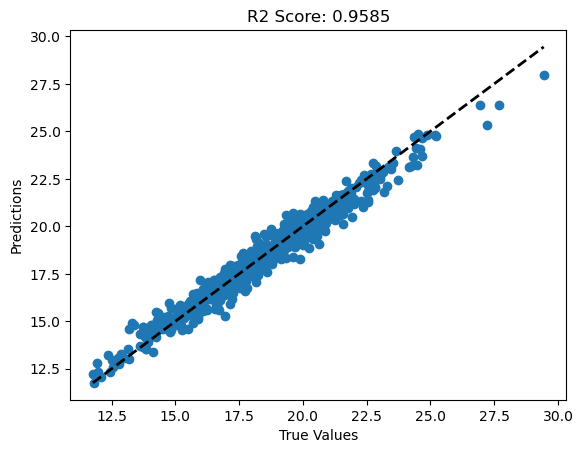

In [42]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
# Calculate metrics
r2 = r2_score(Y_val_tensor.numpy(), val_outputs.numpy())

plt.scatter(Y_val_tensor.numpy(), val_outputs.numpy())
plt.plot([Y_val_tensor.min(), Y_val_tensor.max()], [Y_val_tensor.min(), Y_val_tensor.max()], 'k--', lw=2)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title(f'R2 Score: {r2:.4f}')